# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import time
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from IPython.display import Image
from sklearn.tree import export_graphviz



from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
# from plot_roc import *

from sklearn.metrics  import confusion_matrix, classification_report, roc_auc_score

warnings.filterwarnings('ignore')

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import joblib

import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
# from plot_learning import *
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve



from sklearn.feature_selection import SequentialFeatureSelector



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

## Dados 

In [4]:
train = pd.read_parquet('./data/train_feature_engineering.parquet.gzip') 

test = pd.read_parquet('./data/test_feature_engineering.parquet.gzip')

In [5]:
train.head()

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
8616816         0.0  16538200.0  118.0437   7066914.0  173.09610   4560234.0   
4792422         0.0   8518468.0  117.3785   1454243.0   76.24191   2325704.0   
7077495  44858050.0  21146550.0  116.5203  12225280.0   61.58792   1119992.0   
5237336         0.0   7959880.0  116.6375   1244927.0   72.54174   2319337.0   
8320236  38265830.0  13847800.0  117.1559   6002501.0   68.62134   3284403.0   

         QGL  mean_P-TPT_7D_well  mean_T-TPT_7D_well  mean_P-MON-CKP_7D_well  \
8616816  0.0        1.645878e+07          117.965900            6.177805e+06   
4792422  0.0        8.139633e+06          116.291100            9.757301e+05   
7077495  0.0        2.114655e+07          116.481200            1.221827e+07   
5237336  0.0        7.880082e+06          116.327971            9.366789e+05   
8320236  0.0        1.370554e+07          116.293286            5.815453e+06   

         mean_QGL_7D_well  target  
8616816               0.0       1  
4792422               0.0       0  
7077495               0.0       0  
5237336               0.0       0  
8320236               0.0       1

In [6]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL', 'mean_P-TPT_7D_well', 'mean_T-TPT_7D_well', 'mean_P-MON-CKP_7D_well', 'mean_QGL_7D_well']

X_train = train[VARS]
y_train = train.target

In [7]:
X_test = test[VARS]
y_test = test.target

In [8]:
X_train.describe()

P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  7.776283e+06  7.776283e+06  7.776283e+06  7.776283e+06  7.776283e+06   
mean  -3.773320e+40  2.789141e+07  1.082520e+02  4.574691e+06  7.467662e+01   
std    2.076193e+41  2.054327e+08  2.157077e+01  3.595426e+06  3.278656e+01   
min   -1.180116e+42  4.488654e+06  7.236000e+00  7.534167e+05 -2.020000e+00   
25%    0.000000e+00  8.529773e+06  1.164868e+02  1.682391e+06  6.174434e+01   
50%    0.000000e+00  1.412337e+07  1.170522e+02  2.493314e+06  7.322810e+01   
75%    2.383019e+07  1.664394e+07  1.178640e+02  6.179924e+06  7.758095e+01   
max    4.485805e+07  2.941990e+09  1.196061e+02  1.284910e+07  1.730961e+02   

         P-JUS-CKGL           QGL  mean_P-TPT_7D_well  mean_T-TPT_7D_well  \
count  7.776283e+06  7.776283e+06        7.776283e+06        7.776283e+06   
mean   1.134351e+08  1.669527e-01        1.263508e+07        1.048262e+02   
std    4.258422e+08  4.544998e-01        5.159311e+06        2.860055e+01   
min   -4.976717e+05  0.000000e+00        0.000000e+00        0.000000e+00   
25%    2.316301e+06  0.000000e+00        7.999946e+06        1.159359e+02   
50%    2.335133e+06  0.000000e+00        1.334799e+07        1.164435e+02   
75%    4.426037e+06  0.000000e+00        1.645878e+07        1.173802e+02   
max    2.027865e+09  4.146514e+00        2.118654e+07        1.188640e+02   

       mean_P-MON-CKP_7D_well  mean_QGL_7D_well  
count            7.776283e+06      7.776283e+06  
mean             3.912419e+06      7.555598e-02  
std              3.660637e+06      2.854559e-01  
min              0.000000e+00      0.000000e+00  
25%              1.165978e+06      0.000000e+00  
50%              2.044719e+06      0.000000e+00  
75%              5.931414e+06      0.000000e+00  
max              1.227121e+07      1.715941e+00

In [9]:
len(y_test)

3332694

Padronização dos dados

In [10]:
file_std = "./models/scale_feature_engineering.pkl"

scale = joblib.load(file_std)

In [11]:
X_train = scale.transform(X_train)

X_test = scale.transform(X_test)


X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [12]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train).reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test).reset_index(drop=True) 

In [13]:
del X_train
del X_test

In [14]:
for i in VARS:
    train[i] = train[i].astype(float)

for i in VARS:
    test[i] = test[i].astype(float)

In [15]:
train.head()

P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  QGL  \
0    1.0  0.004102  0.986096   0.521963   1.000000    0.002494  0.0   
1    1.0  0.001372  0.980176   0.057940   0.446914    0.001392  0.0   
2    1.0  0.005671  0.972539   0.948426   0.363233    0.000798  0.0   
3    1.0  0.001182  0.973582   0.040635   0.425785    0.001389  0.0   
4    1.0  0.003186  0.978195   0.433963   0.403397    0.001865  0.0   

   mean_P-TPT_7D_well  mean_T-TPT_7D_well  mean_P-MON-CKP_7D_well  \
0            0.776851            0.992444                0.503439   
1            0.384189            0.978354                0.079514   
2            0.998112            0.979954                0.995686   
3            0.371938            0.978664                0.076331   
4            0.646898            0.978373                0.473910   

   mean_QGL_7D_well  target  
0               0.0       1  
1               0.0       0  
2               0.0       0  
3               0.0       0  
4               0.0       1

In [16]:
test[VARS].sample(frac=0.1, random_state=32).shape

(333269, 11)

In [17]:
test_sample = test[VARS].sample(frac=0.1, random_state=36)

### Random Forest

In [31]:
filename = './models/RF_feature_engineering.pkl'


RF_best = joblib.load(filename)
RF_best

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features='log2', min_samples_leaf=50,
                       min_samples_split=100, n_estimators=200, n_jobs=-1,
                       random_state=23)

In [32]:
y_pred_rf = RF_best.predict(test[VARS])

Text(0.5, 1.0, 'Random Forest feature importance')

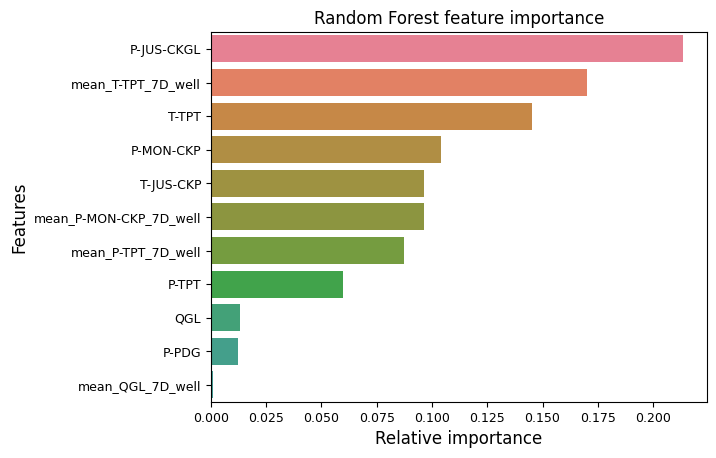

In [18]:
random_palette = sns.color_palette("husl", 20) 

names_classifiers = [("Random Forest",RF_best)]
classifier = names_classifiers[0][1]
name = names_classifiers[0][0]
indices = np.argsort(classifier.feature_importances_)[::-1][:40]
g = sns.barplot(y=train[VARS].columns[indices][:40],x = classifier.feature_importances_[indices][:40] , palette=random_palette, orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")

In [21]:
shap.initjs()
explainer_rf = shap.TreeExplainer(RF_best)
shap_values_rf = explainer_rf.shap_values(test_sample)

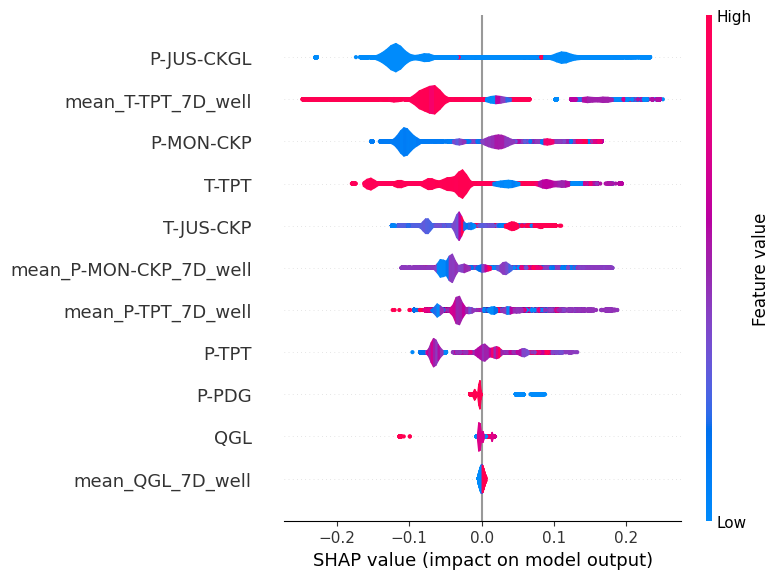

In [22]:
shap.summary_plot(shap_values_rf[:,:,1], test_sample, plot_type="violin", max_display=None, show=False)

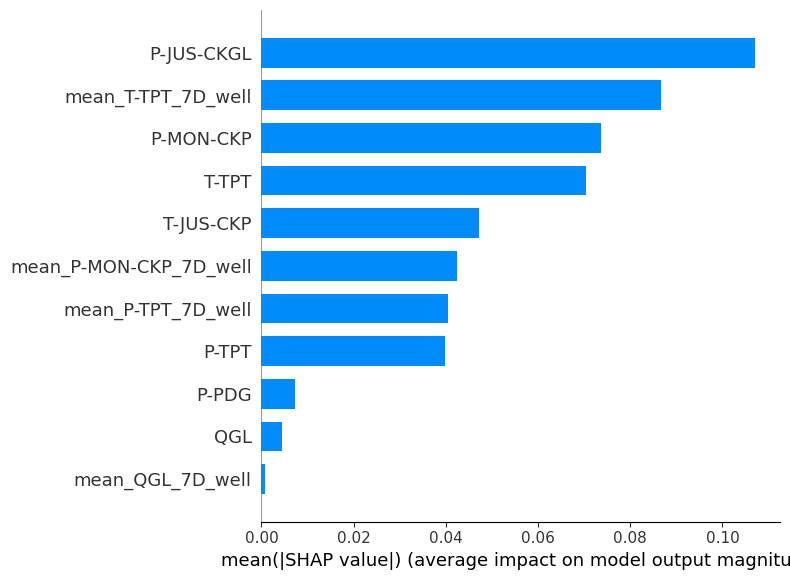

In [31]:
shap.summary_plot(shap_values_rf[:,:,1], test_sample, plot_type="bar", max_display=None, show=False)

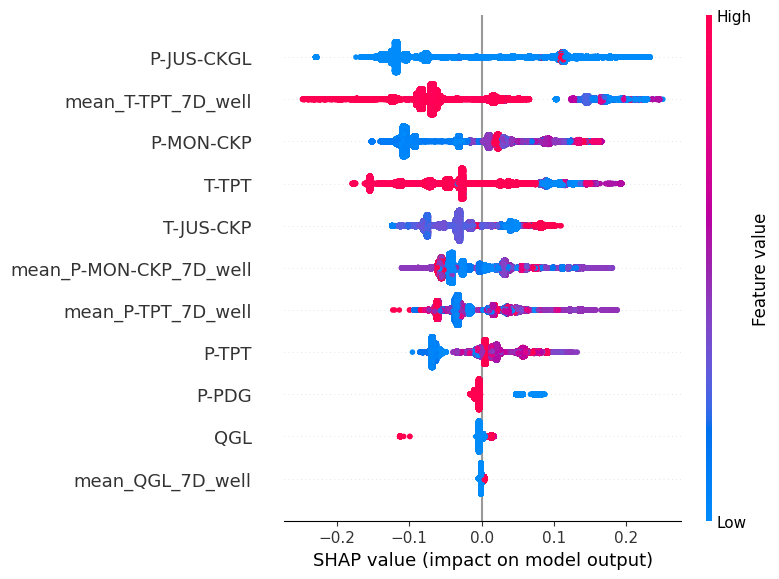

In [32]:
shap.summary_plot(shap_values_rf[:,:,1], test_sample, plot_type="dot", max_display=None, show=False)

### LGBM

In [33]:
filename = './models/LGBM_feature_engineering.pkl'


LGBM_best = joblib.load(filename)
LGBM_best 

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.05, max_depth=12, min_child_samples=100,
               n_estimators=200, n_jobs=-1, num_leaves=32, objective='binary',
               random_state=32)

In [34]:
y_pred_lgbm = LGBM_best.predict(test[VARS])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Text(0.5, 1.0, 'LGBM feature importance')

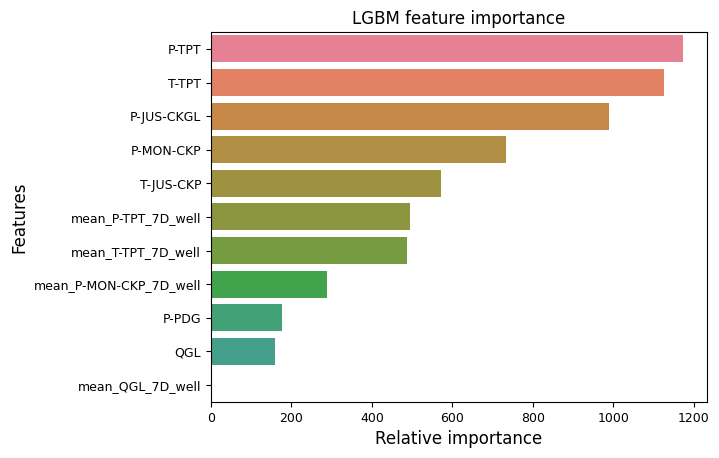

In [17]:
random_palette = sns.color_palette("husl", 20) 

names_classifiers = [("LGBM",LGBM_best)]
classifier = names_classifiers[0][1]
name = names_classifiers[0][0]
indices = np.argsort(classifier.feature_importances_)[::-1][:40]
g = sns.barplot(y=test[VARS].columns[indices][:40],x = classifier.feature_importances_[indices][:40] , palette=random_palette, orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")

In [21]:
shap.initjs()
explainer_lgbm = shap.TreeExplainer(LGBM_best)
shap_values_lgbm = explainer_lgbm.shap_values(test_sample)

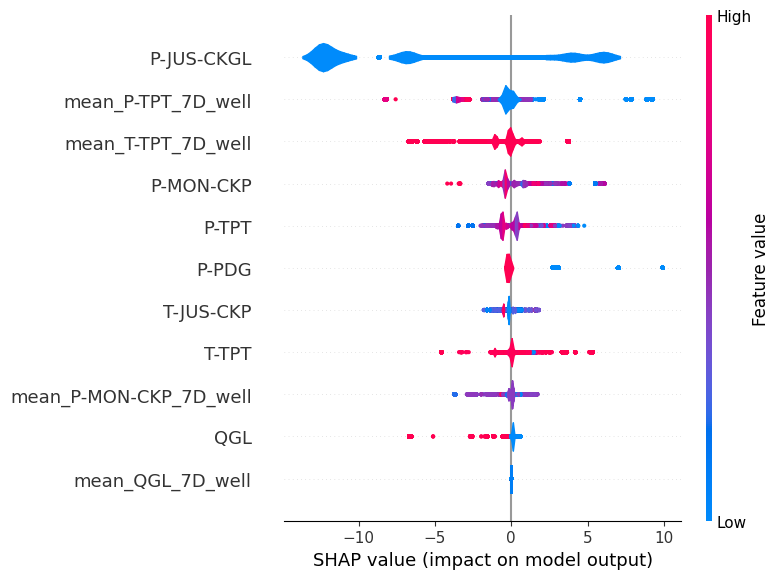

In [22]:
shap.summary_plot(shap_values_lgbm, test_sample, plot_type="violin", max_display=None, show=False)

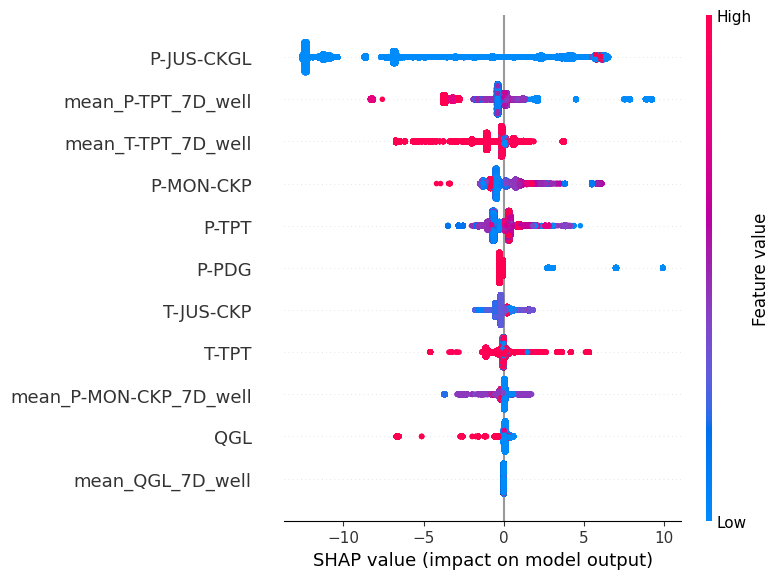

In [23]:
shap.summary_plot(shap_values_lgbm, test_sample, plot_type="dot", max_display=None, show=False)

In [24]:
# shap.summary_plot(shap_values_lgbm, test_sample, plot_type="density", max_display=None, show=False)

In [25]:
# shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm, test_sample.iloc[0:100,:])

shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm[:1000,:], test_sample.iloc[:1000,:])

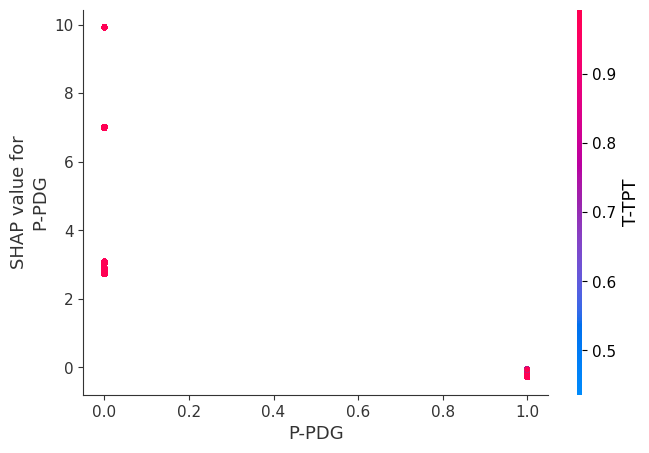

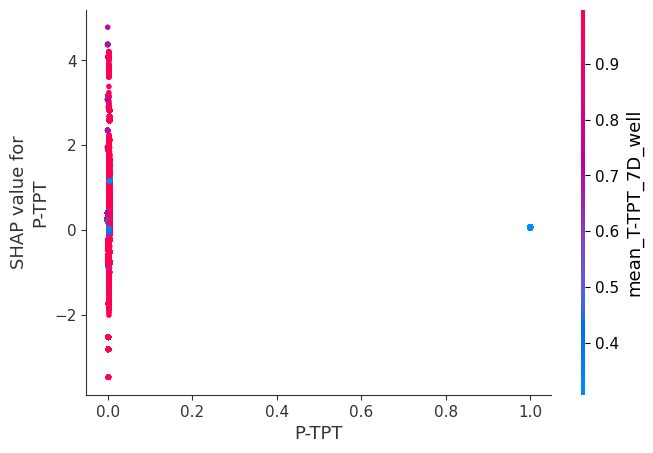

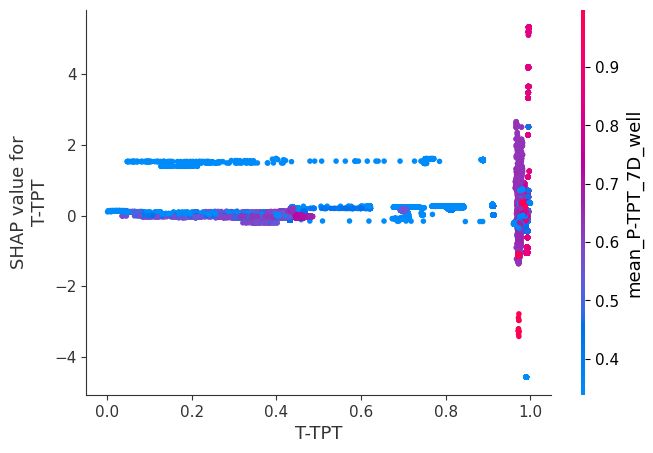

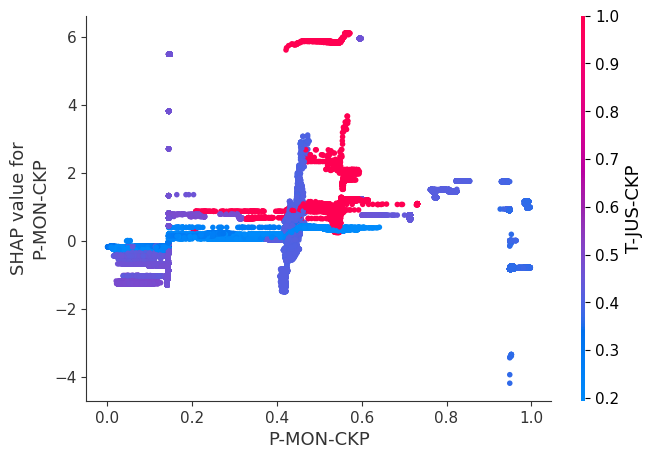

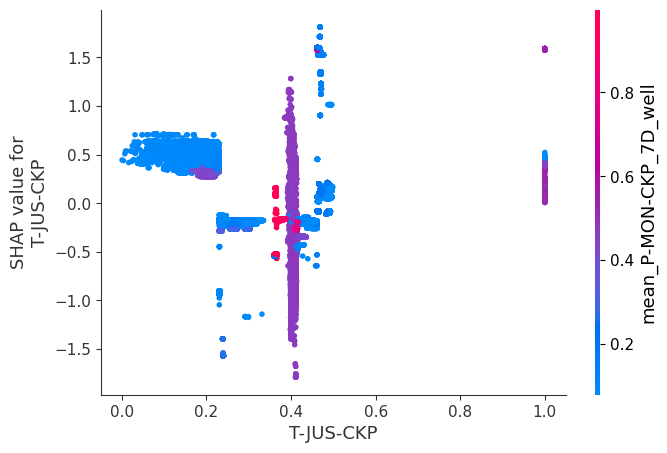

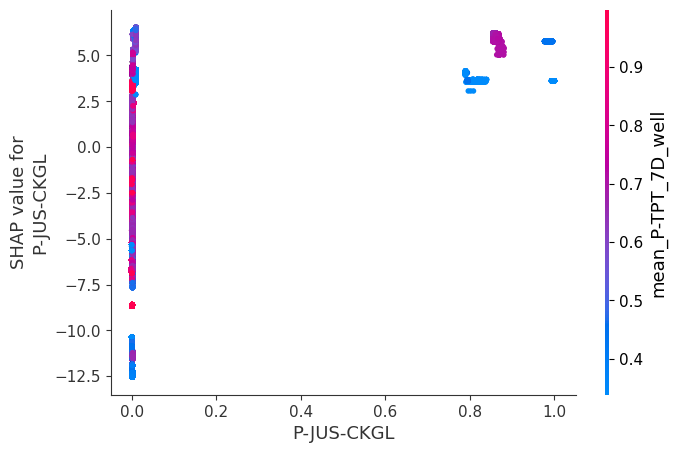

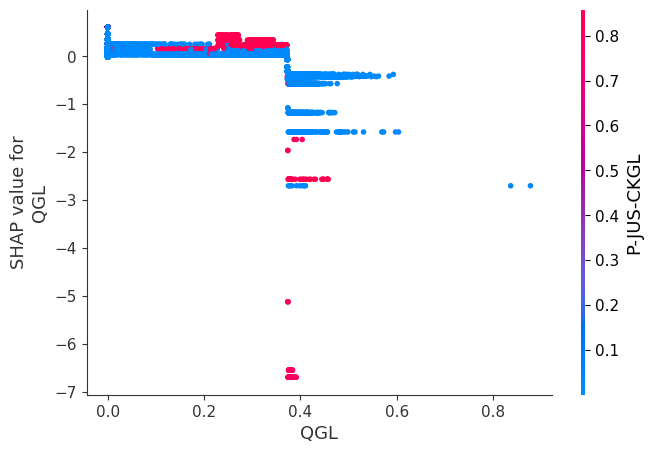

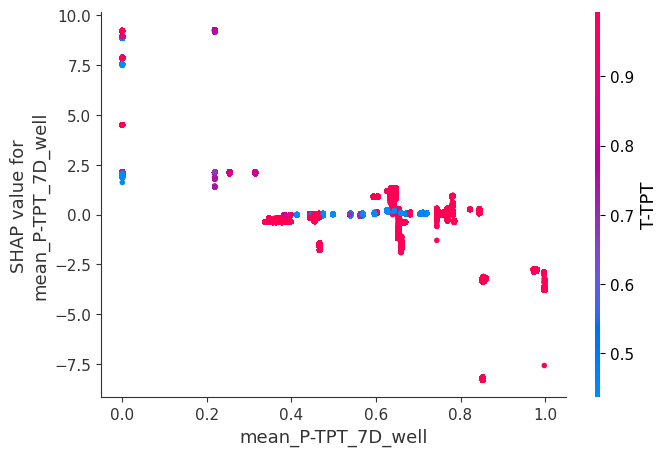

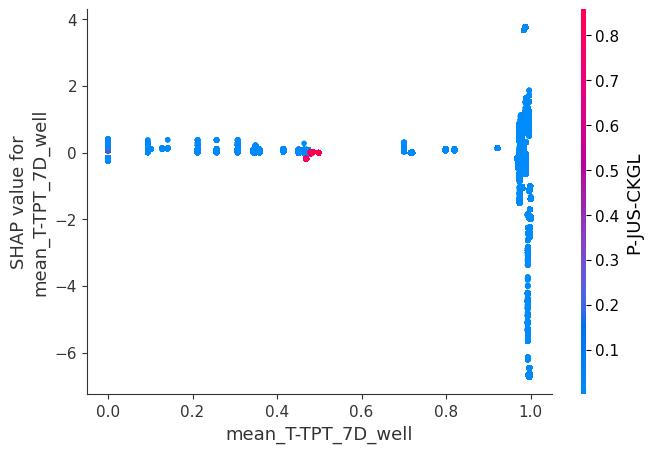

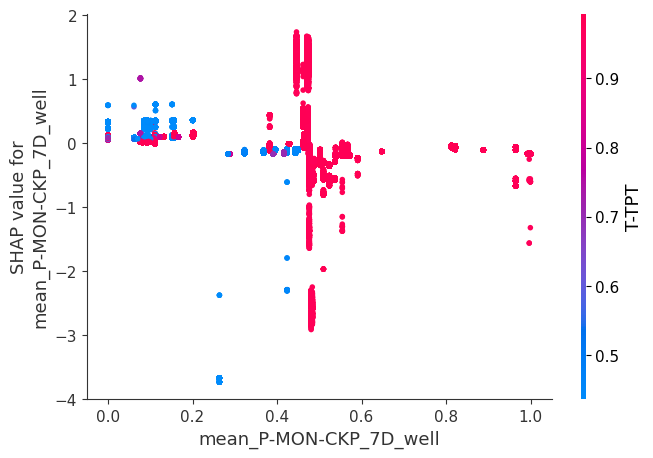

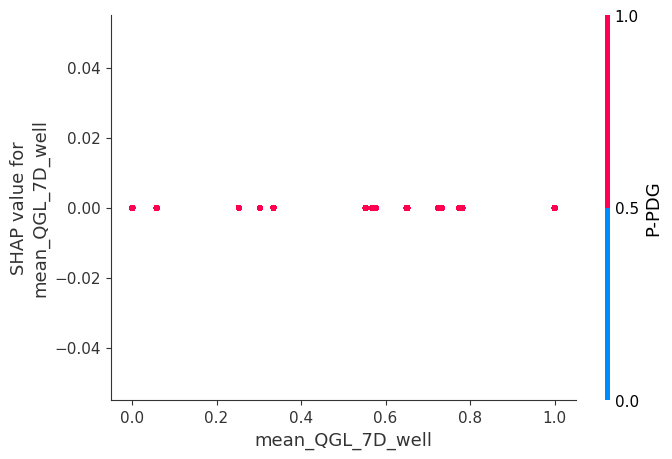

In [26]:
for name in test_sample.columns:
    shap.dependence_plot(name, shap_values_lgbm, test_sample, display_features=test_sample)

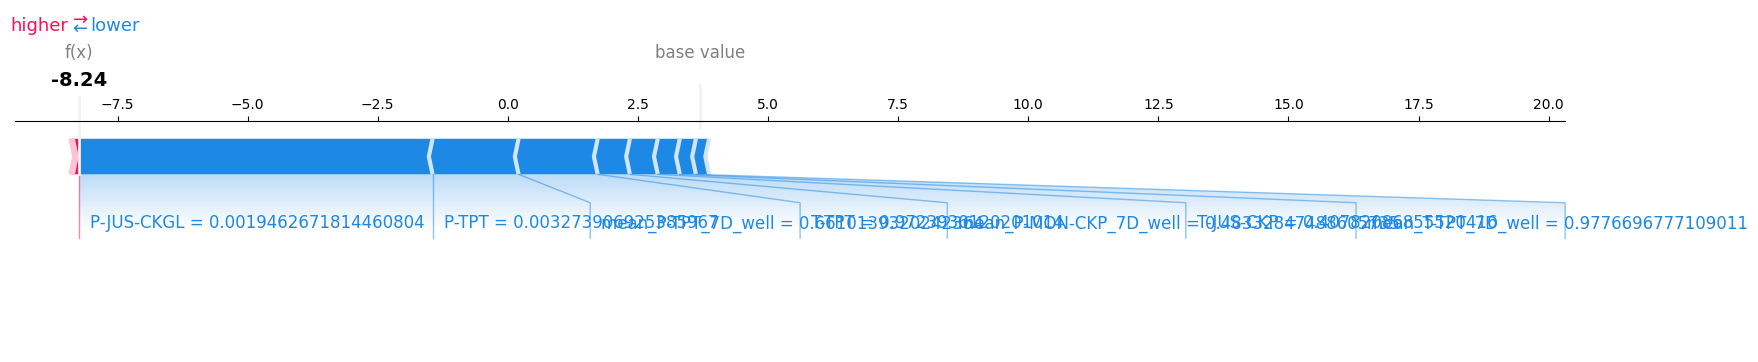

In [27]:
shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm[0,:], test_sample.iloc[0,:], matplotlib=True)

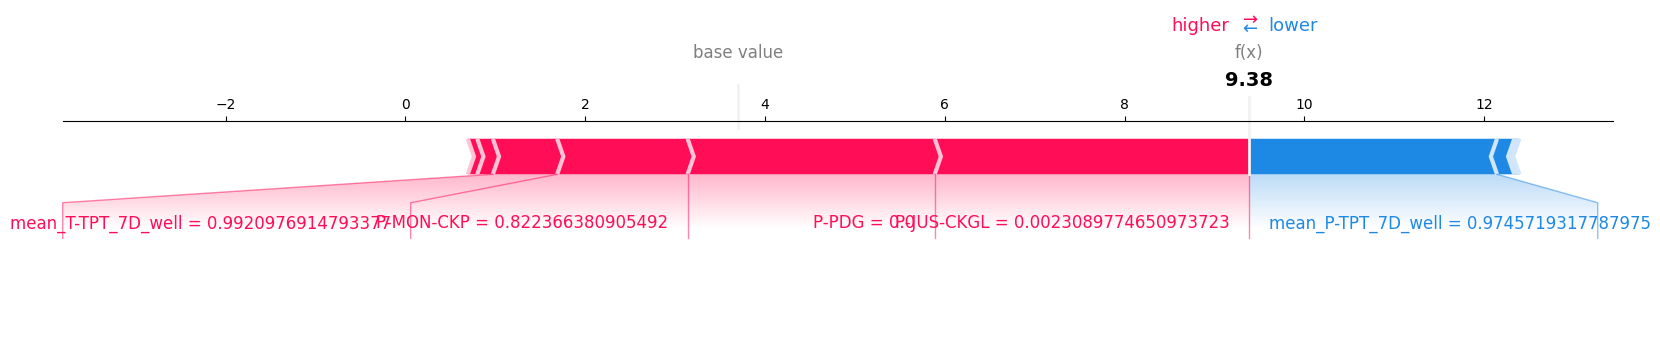

In [28]:
shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm[1,:], test_sample.iloc[1,:], matplotlib=True)

In [34]:
shap_values_lgbm_ = explainer_lgbm(test_sample)

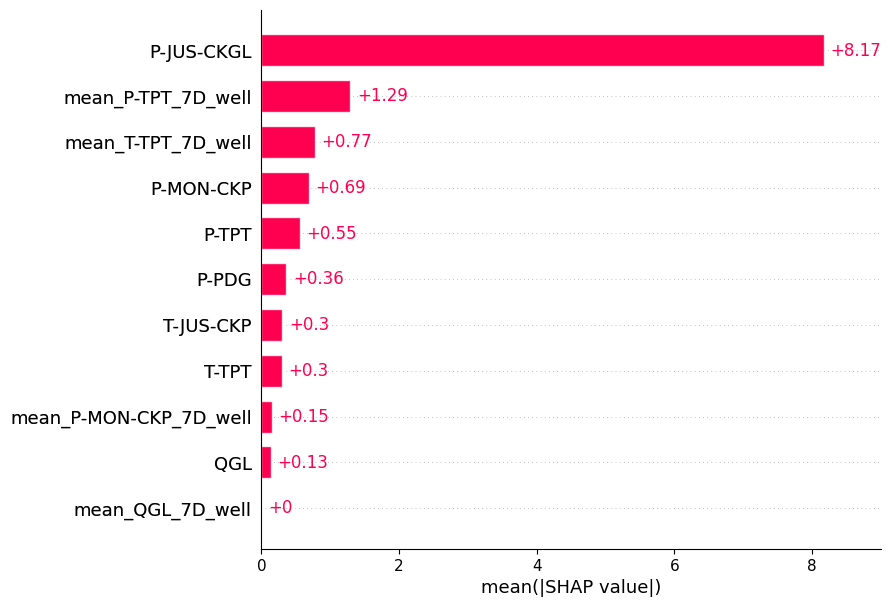

In [35]:
shap.plots.bar(shap_values_lgbm_, max_display=12)

<Axes: xlabel='SHAP value'>

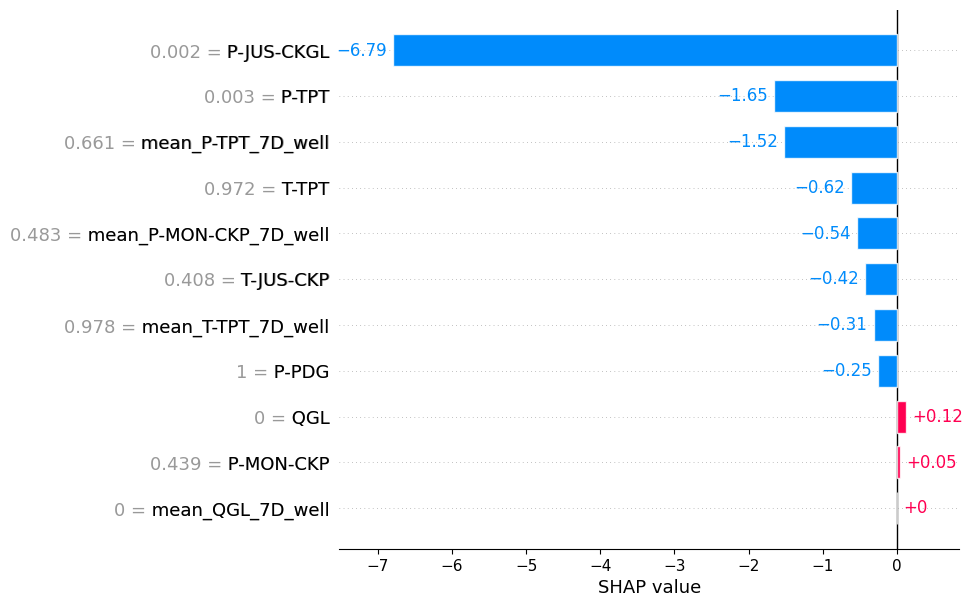

In [36]:
shap.plots.bar(shap_values_lgbm_[0], show=False, max_display=12)

<Axes: xlabel='SHAP value'>

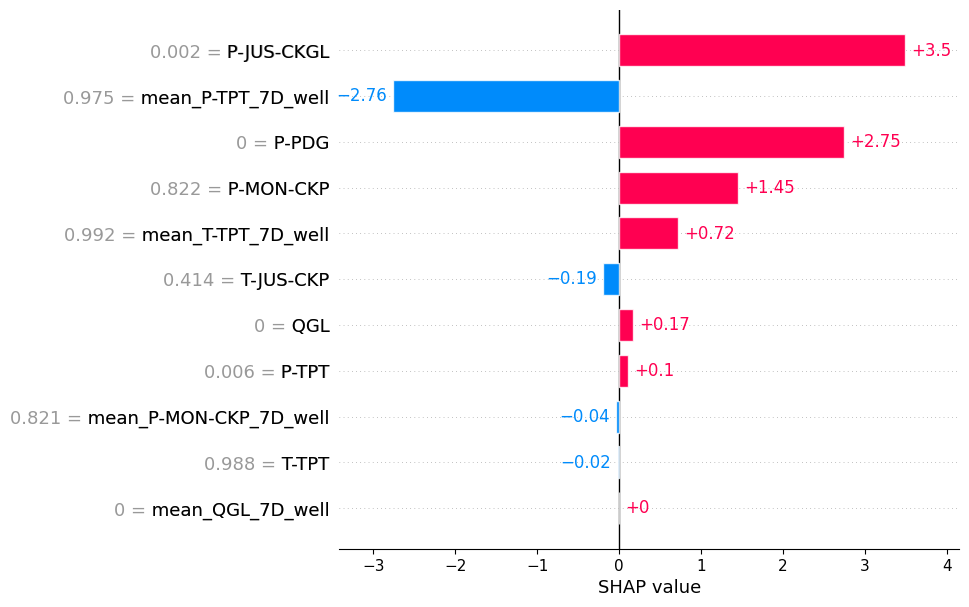

In [37]:
shap.plots.bar(shap_values_lgbm_[1], show=False, max_display=12)

### XGBoosting

In [35]:
filename = './models/XGB_feature_engineering.pkl'

XGB_best = joblib.load(filename)
XGB_best

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=150, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=33, ...)

In [36]:
y_pred_xgb = XGB_best.predict(test[VARS])

In [19]:
shap.initjs()
explainer_xgb = shap.TreeExplainer(XGB_best)
shap_values_xgb = explainer_xgb.shap_values(test_sample)

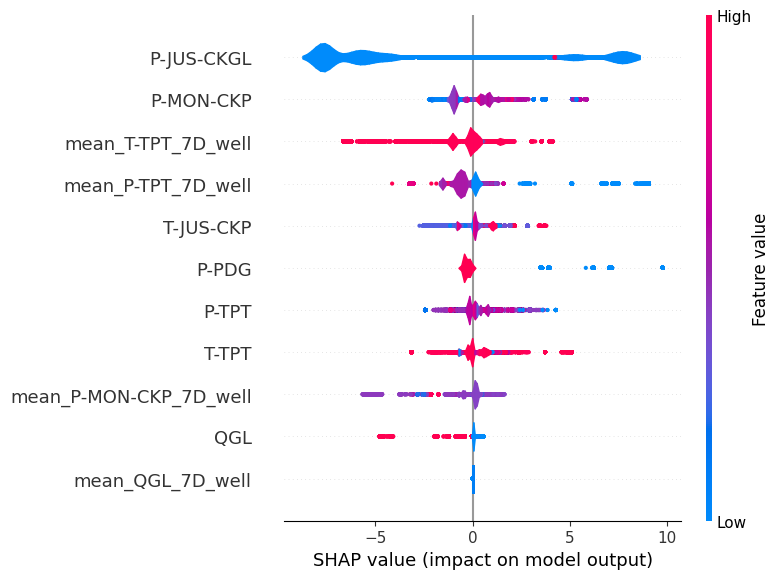

In [20]:
shap.summary_plot(shap_values_xgb, test_sample, plot_type="violin", max_display=None, show=False)

In [21]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:1000,:], test_sample.iloc[:1000,:])

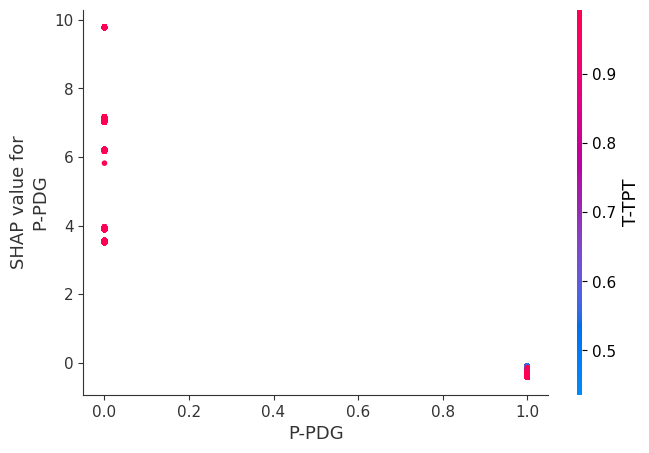

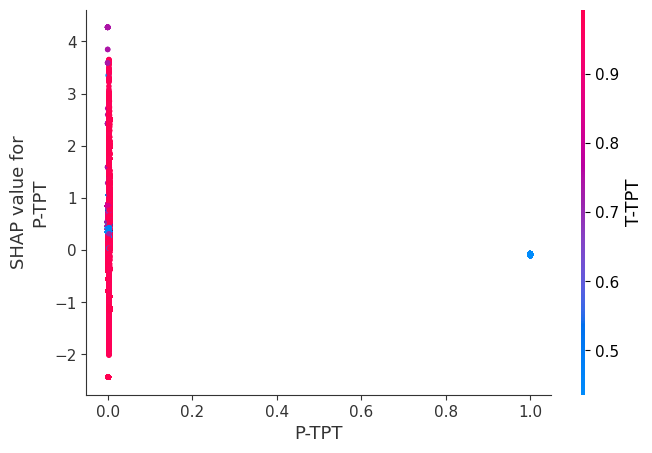

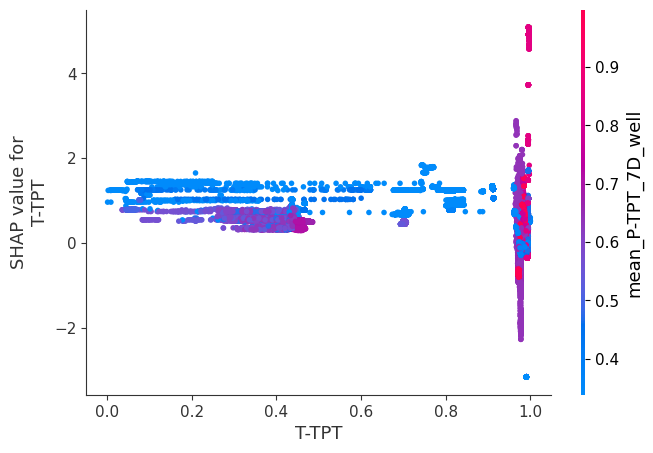

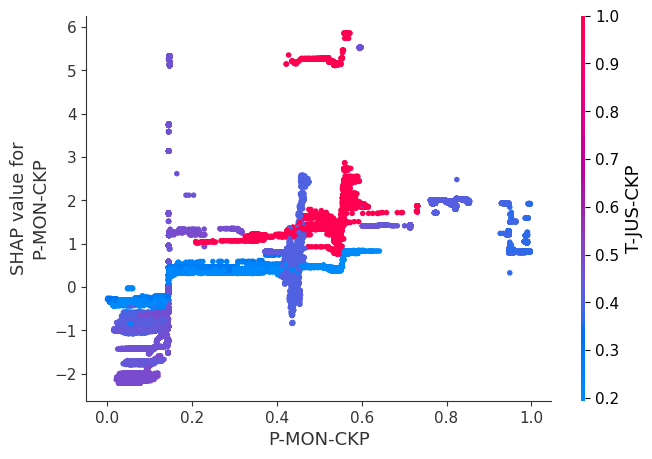

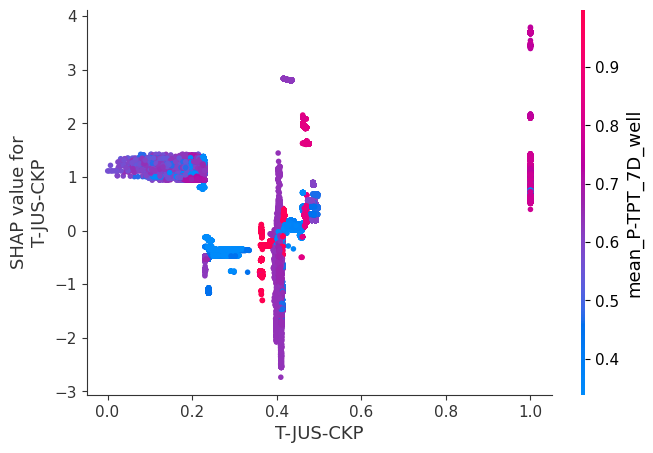

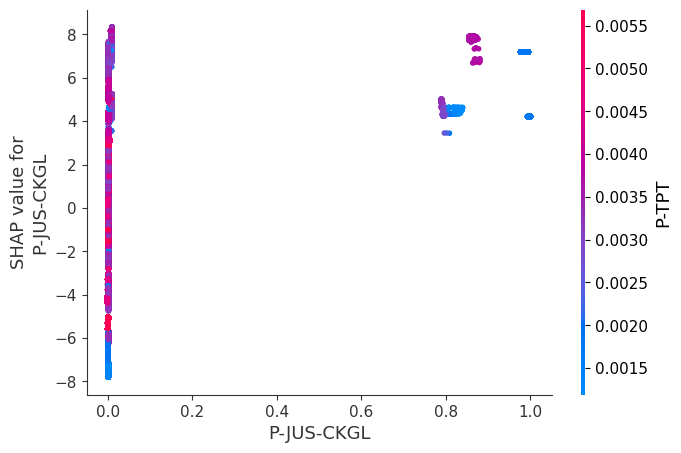

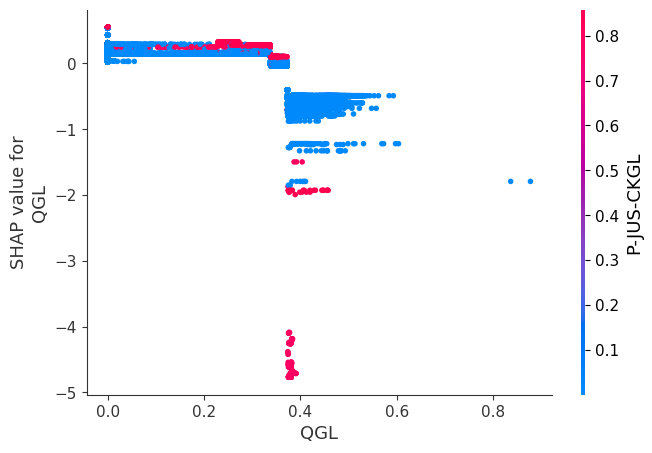

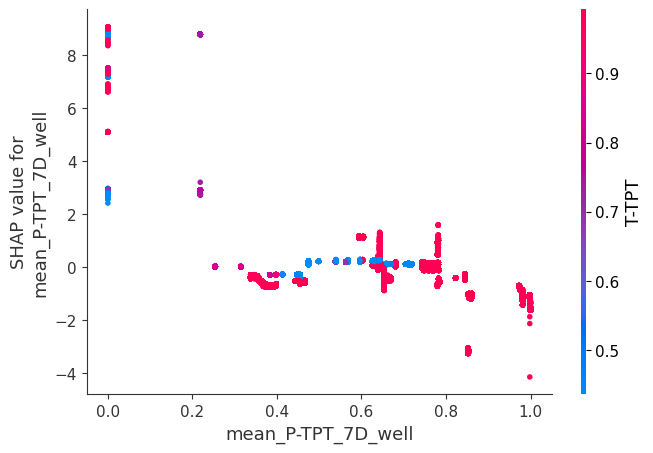

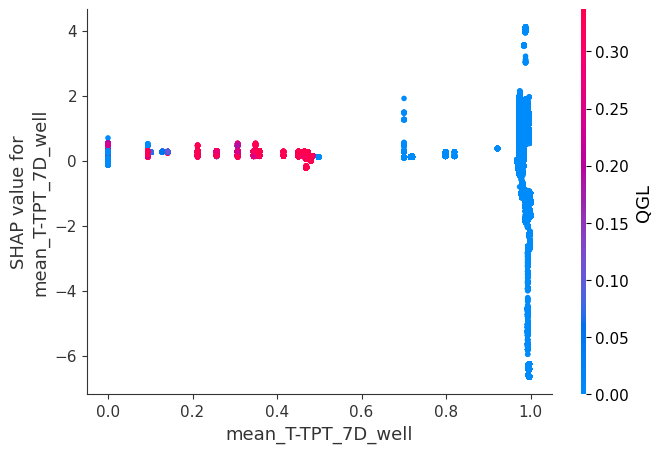

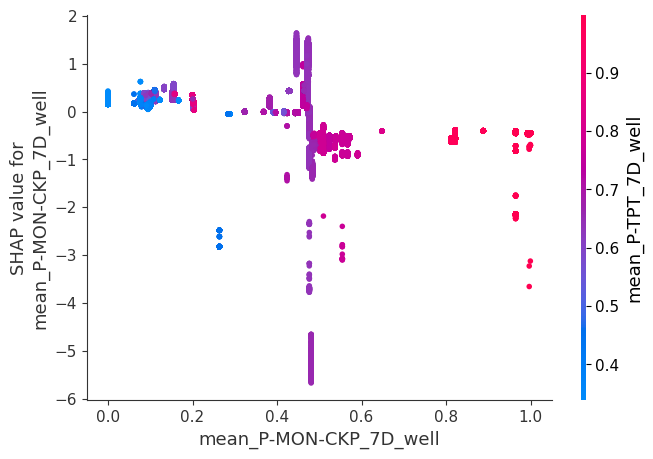

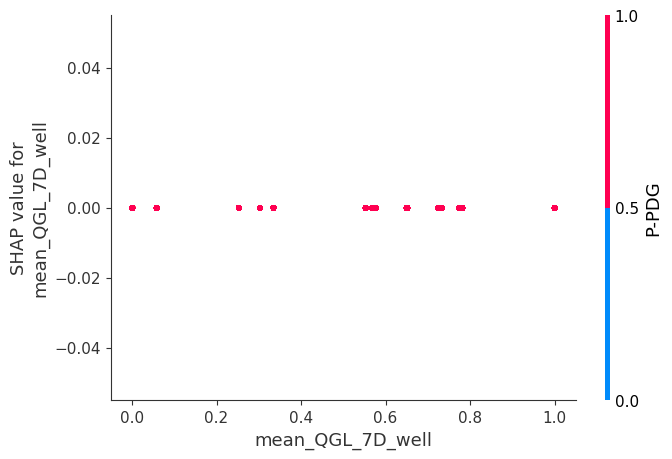

In [22]:
for name in test_sample.columns:S
    shap.dependence_plot(name, shap_values_xgb, test_sample, display_features=test_sample)

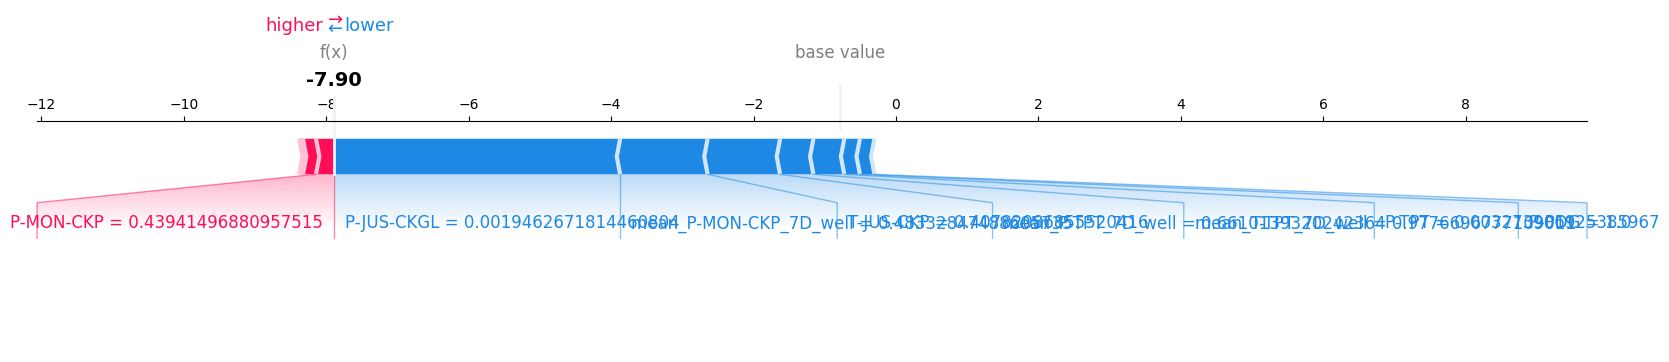

In [23]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], test_sample.iloc[0,:], matplotlib=True)

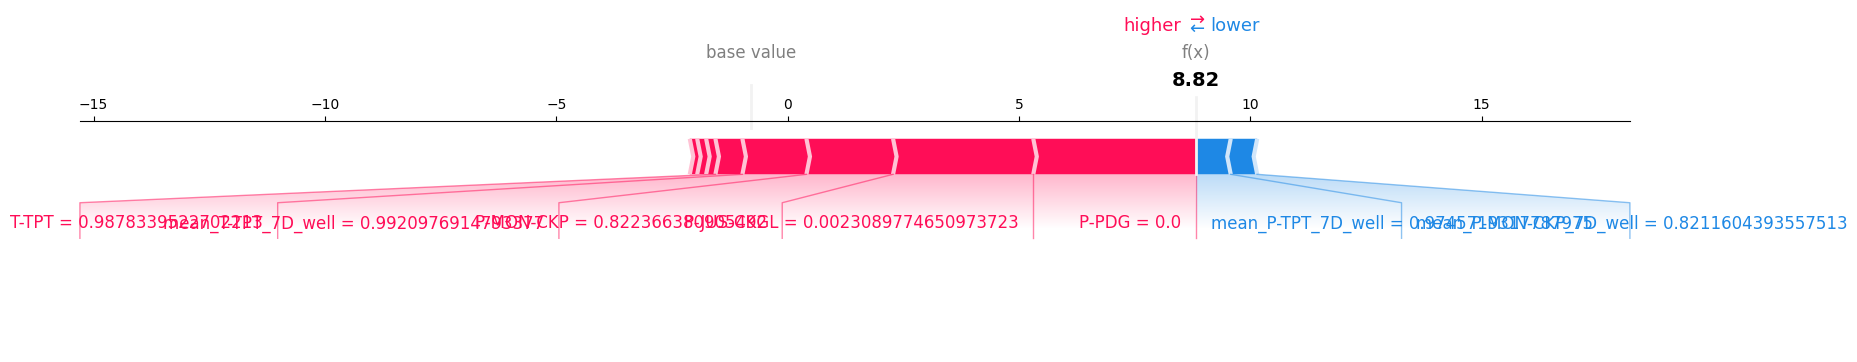

In [24]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[1,:], test_sample.iloc[1,:], matplotlib=True)

In [25]:
shap_values_xgb_ = explainer_xgb(test_sample)

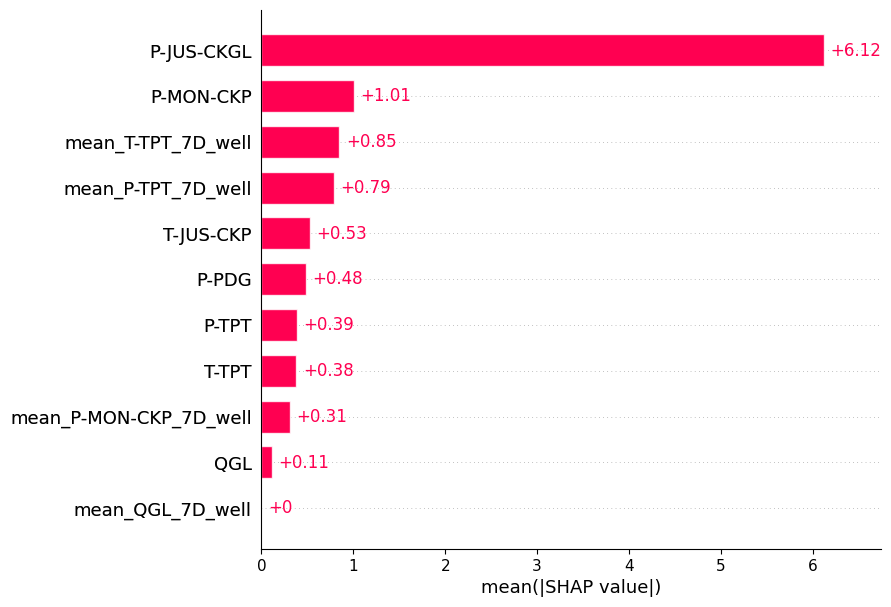

In [26]:
shap.plots.bar(shap_values_xgb_, max_display=12)

<Axes: xlabel='SHAP value'>

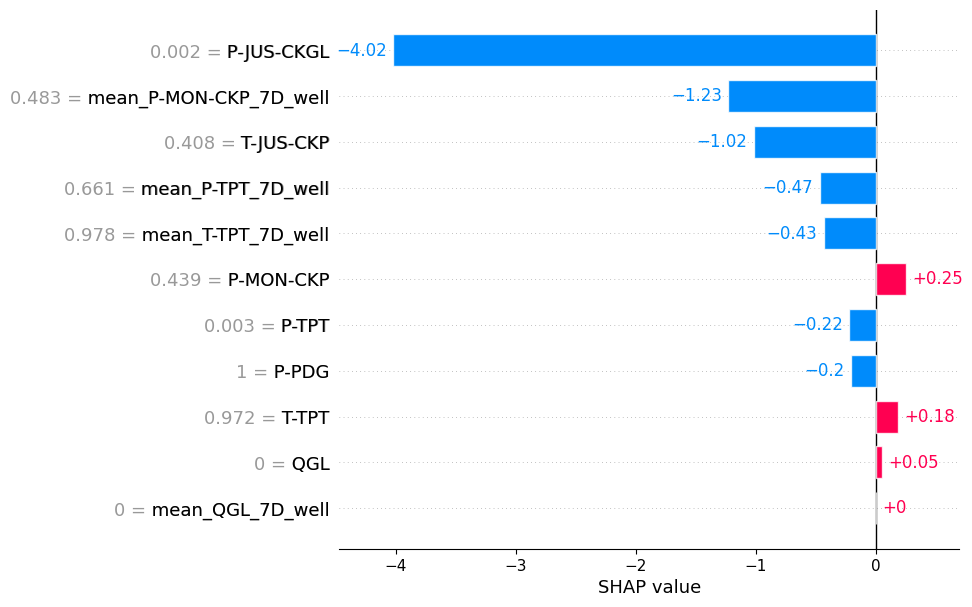

In [27]:
shap.plots.bar(shap_values_xgb_[0], show=False, max_display=12)

<Axes: xlabel='SHAP value'>

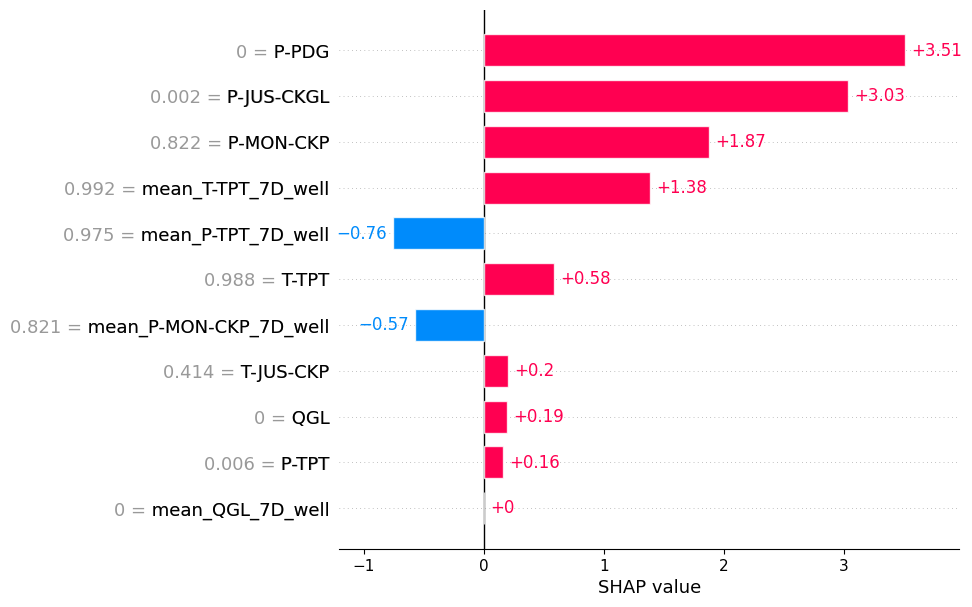

In [28]:
shap.plots.bar(shap_values_xgb_[1], show=False, max_display=12)

### Logistic Regression

In [37]:
filename = './models/LR_feature_engineering.pkl'

LR_best = joblib.load(filename)
LR_best

LogisticRegression(C=0.01, class_weight='balanced', random_state=25)

In [38]:
y_pred_lr = LR_best.predict(test[VARS])

### Teste McNemar's

In [30]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table

In [40]:
table1 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_lr, 
                   y_model2=y_pred_rf)

table1

array([[3133700,     249],
       [ 196032,    2713]])

In [41]:
table1 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_lr, 
                   y_model2=y_pred_rf)

table1

array([[3133700,     249],
       [ 196032,    2713]])

In [42]:
table2 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_lr, 
                   y_model2=y_pred_lgbm)

table2

array([[3133362,     587],
       [ 198090,     655]])

In [43]:
table3 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_lr, 
                   y_model2=y_pred_xgb)

table3

array([[3133517,     432],
       [ 198052,     693]])

In [44]:
table4 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_lgbm, 
                   y_model2=y_pred_rf)

table4

array([[3328955,    2497],
       [    777,     465]])

In [45]:
table5 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_lgbm, 
                   y_model2=y_pred_xgb)

table5

array([[3330600,     852],
       [    969,     273]])

In [46]:
table6 = mcnemar_table(y_target=test.target, 
                   y_model1=y_pred_xgb, 
                   y_model2=y_pred_rf)

table6

array([[3328817,    2752],
       [    915,     210]])

In [47]:
def test_hip(table):
    # calculate mcnemar test
    result = mcnemar(table, exact=True,  correction=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')


def test_hip2(table):
    result = mcnemar(table, exact=True)
    p = result.pvalue
    return p 

In [48]:
print('LR vs RF')
test_hip(table1)
print('LR s LGBM')
test_hip(table2)
print('LR vs XGB')
test_hip(table3)
print('LGBM vs LGBM')
test_hip(table4)
print('LGBM vs XGB')
test_hip(table5)
print('XGB vs RF')
test_hip(table6)

LR vs RF
statistic=249.000, p-value=0.000
Different proportions of errors (reject H0)
LR s LGBM
statistic=587.000, p-value=0.000
Different proportions of errors (reject H0)
LR vs XGB
statistic=432.000, p-value=0.000
Different proportions of errors (reject H0)
LGBM vs LGBM
statistic=777.000, p-value=0.000
Different proportions of errors (reject H0)
LGBM vs XGB
statistic=852.000, p-value=0.007
Different proportions of errors (reject H0)
XGB vs RF
statistic=915.000, p-value=0.000
Different proportions of errors (reject H0)


In [ ]:
labels = ["XGBoost", "LGBM", 'RF', "LR"]
models = [RF_best,, XGB_best, LGBM_best, LR_best]

#set up plotting area
plt.figure(0).clf()

for i, j in enumerate(models):

    plot_roc(j, labels[i])


#add legend
plt.legend()

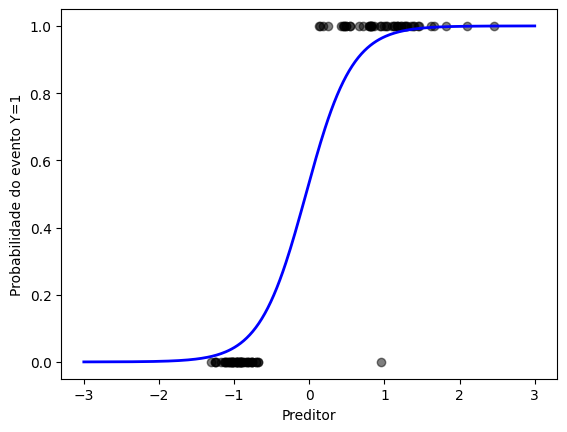

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Gerar dados de exemplo
X, y = make_classification(n_samples=100, n_features=1, n_informative=1, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=42)

# Criar e treinar o modelo de regressão logística
model = LogisticRegression()
model.fit(X, y)

# Plotar os pontos de dados
plt.scatter(X, y, color='black',  alpha=0.5)

# Plotar a curva de decisão da regressão logística
X_test = np.linspace(-3, 3, 300).reshape(-1, 1)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
plt.plot(X_test, y_prob, color='blue', linewidth=2)

# Configurar rótulos e título
plt.xlabel('Preditor')
plt.ylabel('Probabilidade do evento Y=1')
# plt.title('Logistic Regression')

# Exibir o gráfico
plt.show()